# Junior Data Scientist position - Interview Assignment

One of SeaLights product offerings is called "Risk Mitigation", where SeaLights helps dev. teams to identify risky code areas and close them by adding tests. 

The task here is to introduce a new risk type of "Testing Standards", in which the tests for an added/modified piece code is compared against SIMILAR pieces of code and how they are tested. 

In order to drive this feature, we first need to be able to tell for each code element (methods/functions, to limit the scope), which other code elements are similar to it.

In this notebook, we will try to  implement a code similarity function, where we find similar methods given an input method.

First, we install all we need for this task:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### EDA ###

In [2]:
df = pd.read_csv("data.csv")
df.head(3)

,id,customer_bsid,file_id,app_bsid,element_key,revision,name,status,type,start_position,end_position,coverage,code_labels,ignore,constructor,getter_setter,anonymous,generated,deprecated,ref_status
0,1_0,SeaLights_7208babf-80af-460a-9df8-fe5866901313,1_0,7208babf-80af-460a-9df8-fe5866901313,a0c3c202-8a36-4b7e-b910-63c78f566b4a,0,public String getFileHeader(),unchanged,method,"{17,null}","{17,null}",NaN,"[{'category':'Team','label':'Agents','isHighPr...","{'testStages':[],'isIgnored':false}",False,False,False,False,False,unchanged
1,1_1,SeaLights_7208babf-80af-460a-9df8-fe5866901313,1_1,7208babf-80af-460a-9df8-fe5866901313,29e72cb4-f9ad-433c-82ac-a1d1ac6bbee2,3,boolean timerExists(),unchanged,method,"{202,null}","{202,null}",NaN,"[{'category':'Team','label':'Agents','isHighPr...","{'testStages':[],'isIgnored':false}",False,False,False,False,False,unchanged
2,1_2,SeaLights_7208babf-80af-460a-9df8-fe5866901313,1_1,7208babf-80af-460a-9df8-fe5866901313,bc8ed3bb-3cd6-4694-aa89-f06d18a82804,1,TaskScheduler getTimer(),unchanged,method,"{206,null}","{209,null}",NaN,"[{'category':'Team','label':'Agents','isHighPr...","{'testStages':[],'isIgnored':false}",False,False,False,False,False,unchanged


We do a little EDA for the DataFrame:

In [3]:
def find_shape(dataframe):
    print('Rows:', dataframe.shape[0])
    print('Columns:', dataframe.shape[1])
    
def check_missing(dataframe):
    if len(dataframe.columns[dataframe.isnull().any()]) == 0:
        print('There are no missing values.')
    else:
        print('Column Name', ' ', 'Number of Missing Values', ' ', 'Percentage of Total')
        for index, value in dataframe.isnull().sum().items():
            if value>0:
                print(index, ' '*(23-len(index)), value, ' '*(18-len(str(value))),'  ', 
                      round(value*100/len(dataframe), 2), "%")

In [4]:
find_shape(df)

Rows: 5254
Columns: 20


Let check if there are some missing values:

In [5]:
check_missing(df)

Column Name   Number of Missing Values   Percentage of Total
coverage                 5254                   100.0 %


The `coverage` column has no value but only the `name` and `status` columns are of interest.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5254 entries, 0 to 5253
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5254 non-null   object 
 1   customer_bsid   5254 non-null   object 
 2   file_id         5254 non-null   object 
 3   app_bsid        5254 non-null   object 
 4   element_key     5254 non-null   object 
 5   revision        5254 non-null   int64  
 6   name            5254 non-null   object 
 7   status          5254 non-null   object 
 8   type            5254 non-null   object 
 9   start_position  5254 non-null   object 
 10  end_position    5254 non-null   object 
 11  coverage        0 non-null      float64
 12  code_labels     5254 non-null   object 
 13  ignore          5254 non-null   object 
 14  constructor     5254 non-null   bool   
 15  getter_setter   5254 non-null   bool   
 16  anonymous       5254 non-null   bool   
 17  generated       5254 non-null   b

The columns which are relevant for us are 'name' and 'status':

In [7]:
df = df[['name','status']]

The different values for `status`:

In [8]:
df.status.value_counts()

unchanged    5080
moved         140
modified       30
added           4
Name: status, dtype: int64

### Transformation of the data ###

In [9]:
data = df[(df['status'] == 'unchanged') | (df['status'] == 'moved')].reset_index().drop(columns=['index', 'status'])

In [10]:
df_new = df[(df['status'] == 'modified') | (df['status'] == 'added')].reset_index().drop(columns=['index', 'status'])

In [11]:
print('Shape of data:', data.shape)
print('Shape of df_new:', df_new.shape)

Shape of data: (5220, 1)
Shape of df_new: (34, 1)


Now we will change the column `name` in order to have better results with the model:

In [12]:
data['method'] = data['name']
data['name'] = data['name'].apply(lambda x: x.replace('(', ' ').replace(')', ' ').replace(',', ' '))
data['name'] = data['name'].apply(lambda x: re.sub(r"(\w)([A-Z])", r"\1 \2", x))

In [13]:
data.sample(5)

,name,method
2627,public void visit Int Insn int int,"public void visitIntInsn(int, int)"
822,public void execute Integer,public void execute(Integer)
4440,public void visit Insn int,public void visitInsn(int)
109,protected boolean is Archive String,protected boolean isArchive(String)
3580,public static String build Name For Code Cover...,public static String buildNameForCodeCoverage(...


### Saving the data ###

In [14]:
dl = data[['name','method']]

In [15]:
dl.to_csv('data_method.csv')

### Analyzing the words in the data ###

In [16]:
lens_char = dl['name'].apply(lambda s: len(s))
lens_word = dl['name'].apply(lambda s: len(s.split()))

<AxesSubplot:ylabel='Frequency'>

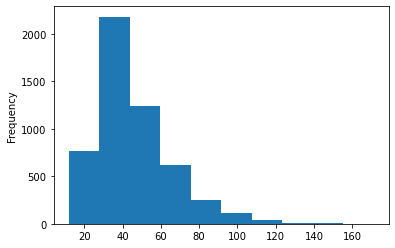

In [17]:
lens_char.plot(kind='hist',bins=10)

<AxesSubplot:ylabel='Frequency'>

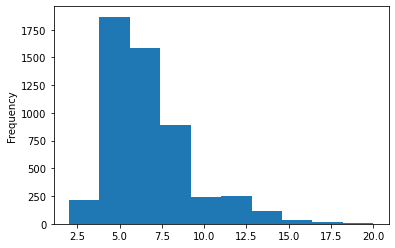

In [18]:
lens_word.plot(kind='hist',bins=10)